## Initialization

In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.preprocessing.dataset import CICIDS2017
from UNSWNB15.preprocessing.dataset import UNSWNB15

from scripts.models.pytorch.MLP import NetworkIntrusionMLP
from scripts.models.pytorch.CNN import NetworkIntrustionCNN
from scripts.models.pytorch.LSTM import NetworkIntrusionLSTM

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(log_dir=f"{root_dir}/logs", log_name="TDM")
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")
logger.info(f"Using device: {device}")

2025-11-20 22:26:06,833 - INFO - Logger initialized for 'TDM_20251120_222606'
2025-11-20 22:26:06,834 - INFO - Using device: cuda:0


## Initialization of the Dataset

In [21]:
full_dataset = CICIDS2017( # [UNSWNB15() or CICIDS2017()]
    dataset_size="small",
    logger=logger
).optimize_memory().encode(attack_encoder="label").scale(scaler="minmax")

2025-11-20 23:25:16,891 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-20 23:25:17,792 - INFO - Loading dataset into DataFrame
2025-11-20 23:25:31,574 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-20 23:25:46,431 - INFO - ============================================================
2025-11-20 23:25:46,431 - INFO - Preprocessing completed successfully
2025-11-20 23:25:46,432 - INFO - Final dimensions: 1,942,693 rows x 71 columns
2025-11-20 23:25:46,433 - INFO - Total rows removed: 271,776 (12.27%)
2025-11-20 23:25:46,433 - INFO - data retention rate: 87.73%
2025-11-20 23:25:46,434 - INFO - ============================================================
2025-11-20 23:25:46,436 - INFO - Optimizing memory usage of the dataset...
2025-11-20 23:25:46,439 - INFO - Initial memory usage: 1067.15 MB
2025-11-20 23:25:47,115 - INFO - Optimized memory usage: 555.81 MB
2025-11-20 23:25:47,115 - INFO - Memory reduction: 511.34 MB (47.92%)
20

In [22]:
full_dataset.distribution(full_dataset.attack_classes)

2025-11-20 23:26:10,253 - INFO - Calculating data distribution...
2025-11-20 23:26:10,263 - INFO - Data Distribution by Attack Type:
2025-11-20 23:26:10,263 - INFO -   0: 1,528,113 instances
2025-11-20 23:26:10,264 - INFO -   2: 193,745 instances
2025-11-20 23:26:10,264 - INFO -   1: 128,016 instances
2025-11-20 23:26:10,265 - INFO -   3: 90,819 instances
2025-11-20 23:26:10,265 - INFO -   4: 2,000 instances


0    1528113
2     193745
1     128016
3      90819
4       2000
Name: count, dtype: int64

In [ ]:
dataset, multiclass = full_dataset.subset(size=50000, multi_class=True)

2025-11-20 22:27:01,065 - INFO - Subsetting dataset to size: 50000...
2025-11-20 22:27:01,078 - INFO - Class distribution before subsetting:
2025-11-20 22:27:01,078 - INFO -   Class 0: 1528113 samples
2025-11-20 22:27:01,079 - INFO -   Class 1: 128016 samples
2025-11-20 22:27:01,079 - INFO -   Class 2: 193745 samples
2025-11-20 22:27:01,079 - INFO -   Class 3: 90819 samples
2025-11-20 22:27:01,080 - INFO -   Class 4: 2000 samples
2025-11-20 22:27:01,147 - INFO - Subsetted dataset to size: 42000


In [4]:
dataset.distribution(dataset.attack_classes if multiclass else dataset.binary_classes)

2025-11-20 22:27:01,251 - INFO - Calculating data distribution...
2025-11-20 22:27:01,253 - INFO - Data Distribution by Attack Type:
2025-11-20 22:27:01,253 - INFO -   0: 10,000 instances
2025-11-20 22:27:01,253 - INFO -   1: 10,000 instances
2025-11-20 22:27:01,254 - INFO -   2: 10,000 instances
2025-11-20 22:27:01,254 - INFO -   3: 10,000 instances
2025-11-20 22:27:01,254 - INFO -   4: 2,000 instances


0    10000
1    10000
2    10000
3    10000
4     2000
Name: count, dtype: int64

In [5]:
X_train, X_val, y_train, y_val = dataset.split(
    one_hot=True,
    apply_smote=True,
    to_tensor=True
)

2025-11-20 22:27:01,264 - INFO - Splitting dataset into training and testing sets...
2025-11-20 22:27:01,274 - INFO - Class distribution before SMOTE:
2025-11-20 22:27:01,275 - INFO -   Class 0: 7941 samples
2025-11-20 22:27:01,276 - INFO -   Class 1: 8001 samples
2025-11-20 22:27:01,276 - INFO -   Class 2: 8027 samples
2025-11-20 22:27:01,277 - INFO -   Class 3: 8006 samples
2025-11-20 22:27:01,277 - INFO -   Class 4: 1625 samples
2025-11-20 22:27:01,723 - INFO - Applied SMOTE to balance the training set.
2025-11-20 22:27:01,725 - INFO - Class distribution after SMOTE:
2025-11-20 22:27:01,726 - INFO -   Class 0: 8027 samples
2025-11-20 22:27:01,726 - INFO -   Class 1: 8027 samples
2025-11-20 22:27:01,727 - INFO -   Class 2: 8027 samples
2025-11-20 22:27:01,728 - INFO -   Class 3: 8027 samples
2025-11-20 22:27:01,729 - INFO -   Class 4: 8027 samples


In [6]:
# Create DataLoaders
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
val_dataset = TensorDataset(X_val.to(device), y_val.to(device))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
input_size = train_loader.dataset.tensors[0].shape[1]
num_classes = train_loader.dataset.tensors[1].shape[1]
print(f"Input size: {input_size}, Num classes: {num_classes}")

model_type = f"{input_size}x{num_classes}"

criterion = nn.CrossEntropyLoss()

Input size: 70, Num classes: 5


## Multi Layers Perceptron (MLP)

In [8]:
model_mlp = NetworkIntrusionMLP(input_size=input_size, num_classes=num_classes).to(device)
logger.info(f"MLP Model initialized with {model_mlp.num_params()} parameters")

learning_rate_mlp = 1e-2
num_epochs_mlp = 1000

mlp_title = f"MLP_{model_type}_{num_epochs_mlp}"

optimizer_mlp = optim.AdamW(model_mlp.parameters(), lr=learning_rate_mlp)
scheduler_mlp = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mlp, mode='min', factor=0.8, patience=10, min_lr=1e-6)

2025-11-20 22:27:01,914 - INFO - MLP Model initialized with 20485 parameters


In [9]:
model_mlp, train_losses_mlp, val_losses_mlp = train(
    model=model_mlp,
    optimizer=optimizer_mlp,
    scheduler=scheduler_mlp,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_mlp
)

model_mlp.save_model(f"{root_dir}/saved_models/{mlp_title}.pt")

Loss: 0.9305, Val Loss: 0.9365, LR: 0.000001: 100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s]


2025-11-20 22:43:12,600 - INFO - Plotting loss curve...
2025-11-20 22:43:13,365 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/loss_img/TDM_20251120_222606_MLP_70x5_1000_loss.png


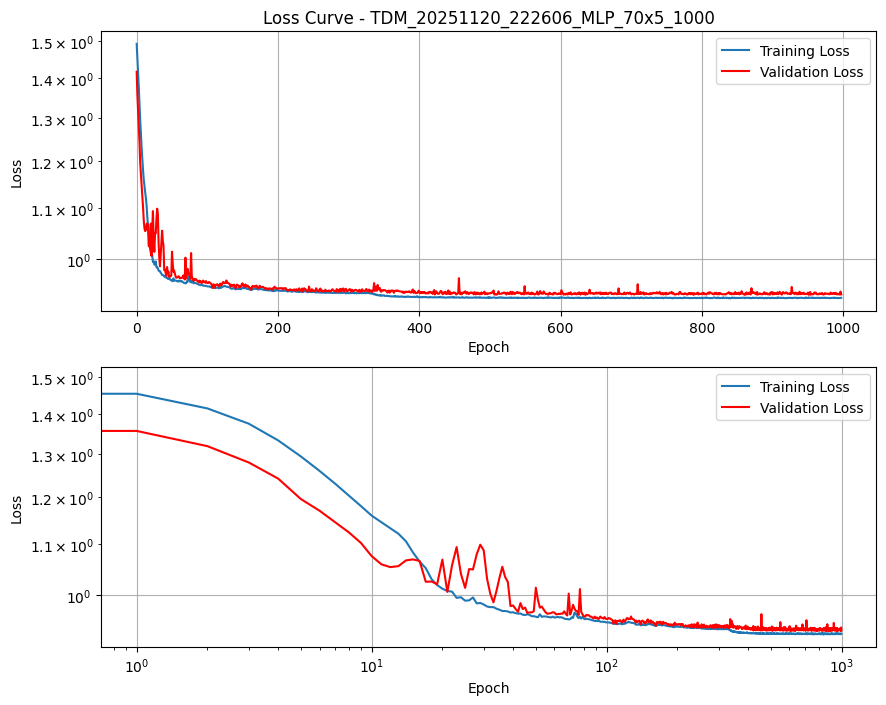

In [10]:
display_loss(
    list_epoch_loss=train_losses_mlp,
    list_val_loss=val_losses_mlp,
    title=f"{title}_{mlp_title}",
    dir=root_dir,
    logger=logger,
    epoch_min=2
)

2025-11-20 22:43:13,583 - INFO - Running analysis for PyTorch model: TDM_20251120_222606_MLP_70x5_1000 on device: cuda:0


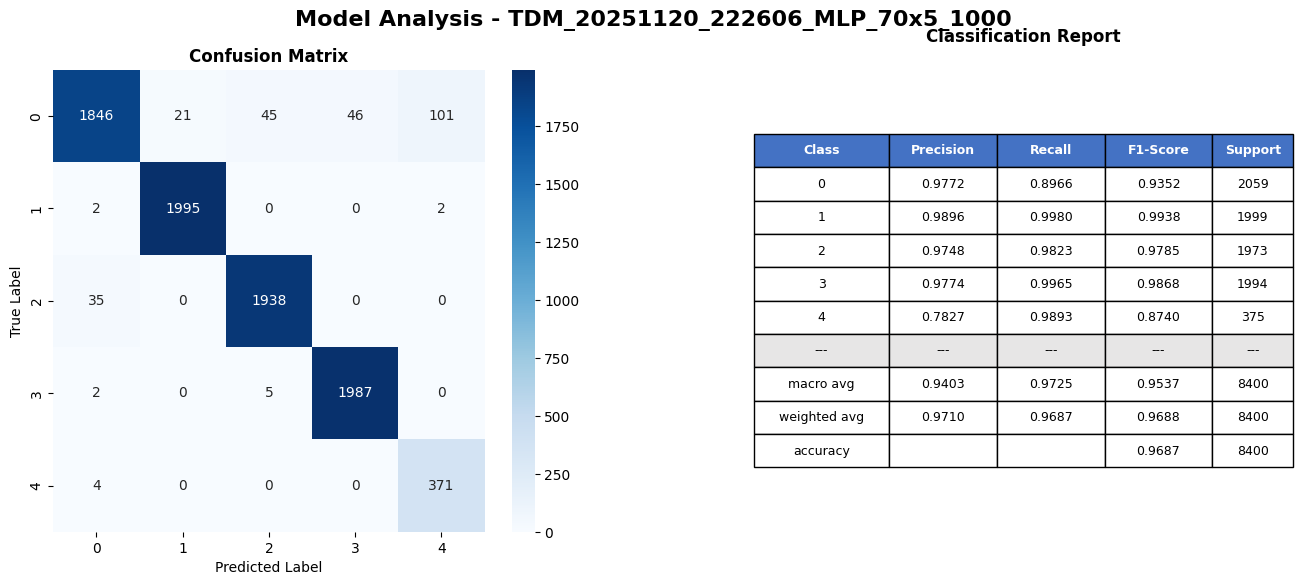

In [11]:
cm, cr = perform_model_analysis(
    model=model_mlp,
    X_test=X_val,
    y_test=y_val,
    logger=logger,
    model_name=f"{title}_{mlp_title}",
    dir=root_dir,
    plot=True,
    device=device
)

model_mlp = model_mlp.cpu()

## Convolutional Neural Network (CNN)

In [12]:
model_cnn = NetworkIntrustionCNN(input_channels=1, input_size= input_size, num_classes=num_classes).to(device)
logger.info(f"CNN Model initialized with {model_cnn.num_params()} parameters")

learning_rate_cnn = 1e-2
num_epochs_cnn = 1000

cnn_title = f"CNN_{model_type}_{num_epochs_cnn}"

optimizer_cnn = optim.AdamW(model_cnn.parameters(), lr=learning_rate_cnn)
scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='min', factor=0.8, patience=10, min_lr=1e-6)

2025-11-20 22:43:14,180 - INFO - CNN Model initialized with 95173 parameters


In [13]:
model_cnn, train_loss_cnn, val_loss_cnn = train(
    model=model_cnn,
    optimizer=optimizer_cnn,
    scheduler=scheduler_cnn,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_cnn
)

model_cnn.save_model(f"{root_dir}/saved_models/{cnn_title}.pt")

Loss: 1.1006, Val Loss: 1.0312, LR: 0.000001: 100%|██████████| 1000/1000 [17:21<00:00,  1.04s/it]


2025-11-20 23:00:35,413 - INFO - Plotting loss curve...
2025-11-20 23:00:36,061 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/loss_img/TDM_20251120_222606_CNN_70x5_1000_loss.png


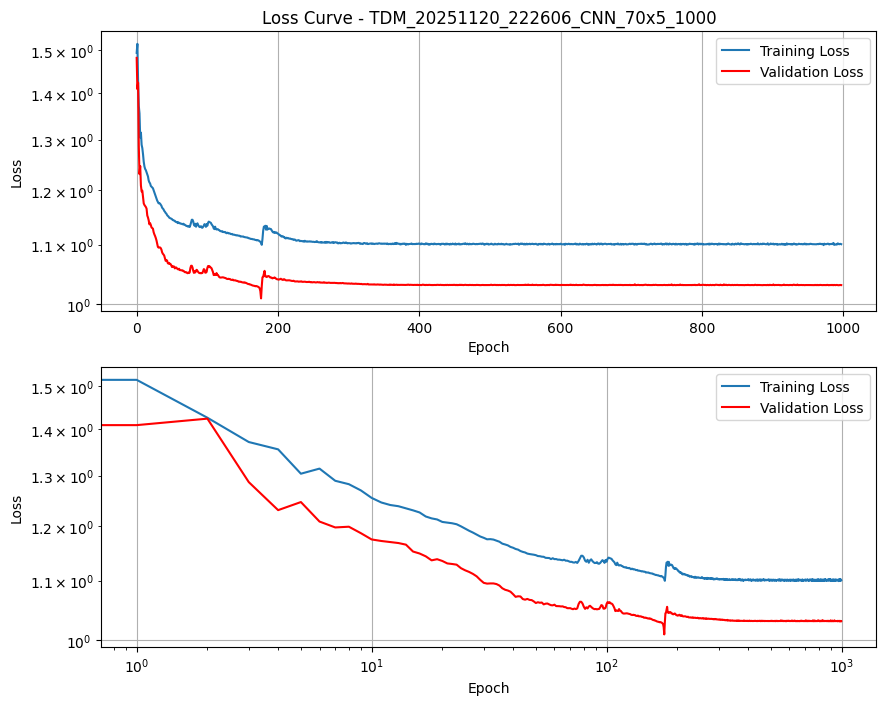

In [14]:
display_loss(
    train_loss_cnn,
    val_loss_cnn,
    title=f"{title}_{cnn_title}",
    dir=root_dir,
    logger=logger,
    epoch_min=2
)

2025-11-20 23:00:36,280 - INFO - Running analysis for PyTorch model: TDM_20251120_222606_CNN_70x5_1000 on device: cuda:0


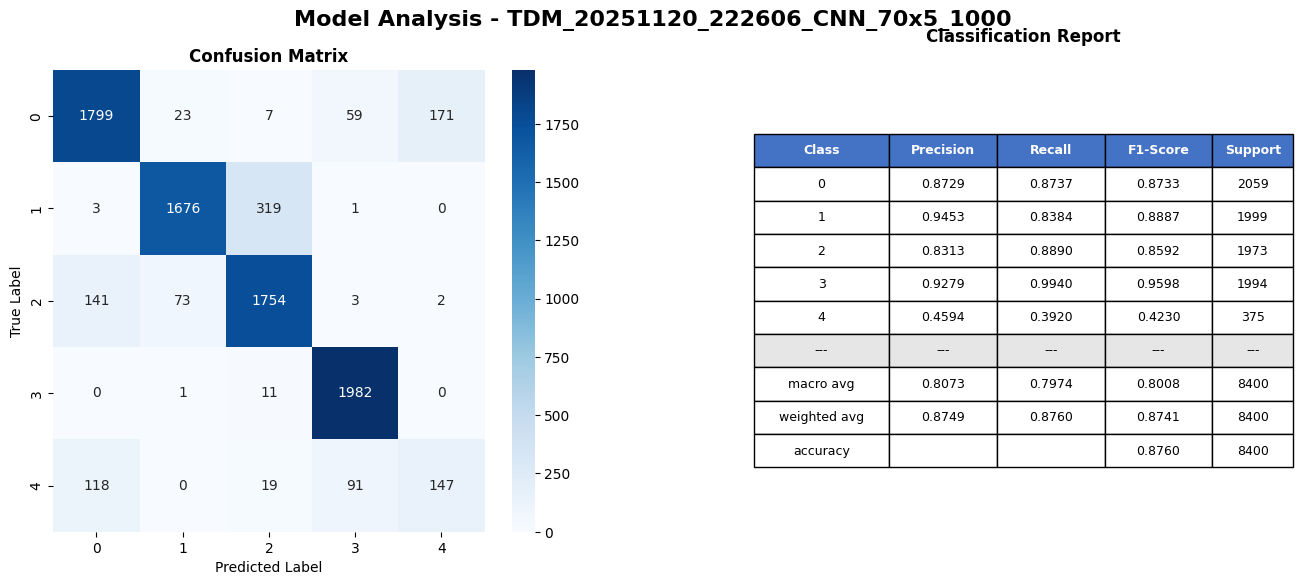

In [15]:
cm, cr = perform_model_analysis(
    model=model_cnn,
    X_test=X_val,
    y_test=y_val,
    model_name=f"{title}_{cnn_title}",
    dir=root_dir,
    plot=True,
    logger=logger,
    device=device
)

model_cnn = model_cnn.cpu()

## Long Short-Term Memory (LSTM)

In [16]:
model_lstm = NetworkIntrusionLSTM(input_size=input_size, hidden_size=64, num_layers=3, num_classes=num_classes).to(device)
logger.info(f"LSTM Model initialized with {model_lstm.num_params()} parameters")

learning_rate_lstm = 1e-2
num_epochs_lstm = 1000

lstm_title = f"LSTM_{model_type}_{num_epochs_lstm}"

optimizer_lstm = optim.AdamW(model_lstm.parameters(), lr=learning_rate_lstm)
scheduler_lstm = optim.lr_scheduler.ReduceLROnPlateau(optimizer_lstm, mode='min', factor=0.8, patience=10, min_lr=1e-6)

2025-11-20 23:00:36,893 - INFO - LSTM Model initialized with 103621 parameters


In [17]:
model_lstm, train_loss_lstm, val_loss_lstm = train(
    model=model_lstm,
    optimizer=optimizer_lstm,
    scheduler=scheduler_lstm,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_lstm
)

model_lstm.save_model(f"{root_dir}/saved_models/{lstm_title}.pt")

Loss: 1.0001, Val Loss: 1.0121, LR: 0.000001: 100%|██████████| 1000/1000 [22:49<00:00,  1.37s/it]


2025-11-20 23:23:26,056 - INFO - Plotting loss curve...
2025-11-20 23:23:26,722 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/loss_img/TDM_20251120_222606_LSTM_70x5_1000_loss.png


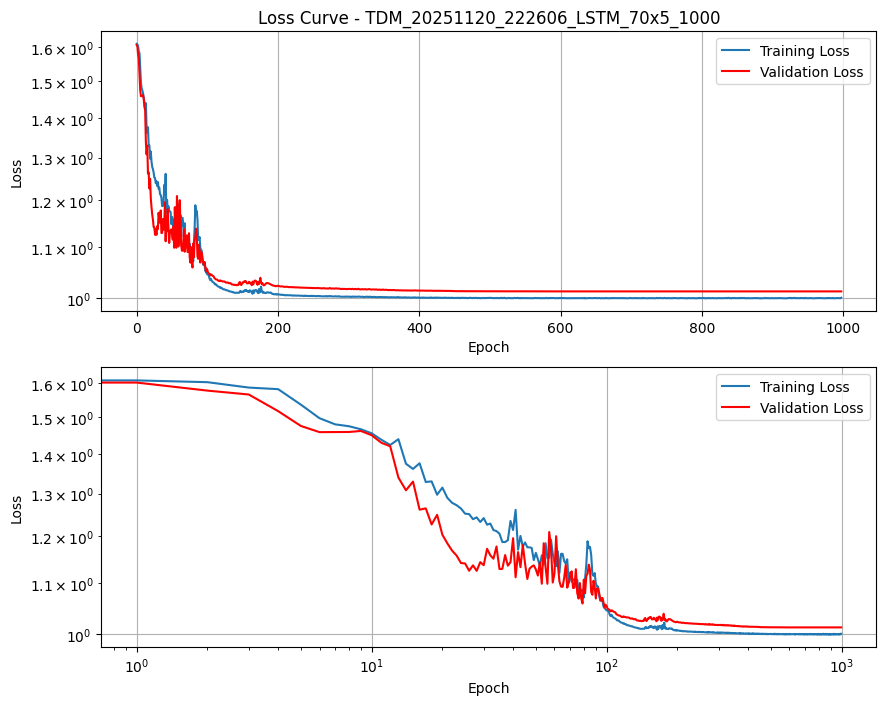

In [18]:
display_loss(
    train_loss_lstm, 
    val_loss_lstm, 
    title=f"{title}_{lstm_title}",
    dir=root_dir, 
    logger=logger,
    epoch_min=2
)

2025-11-20 23:23:26,956 - INFO - Running analysis for PyTorch model: TDM_20251120_222606_LSTM_70x5_1000 on device: cuda:0


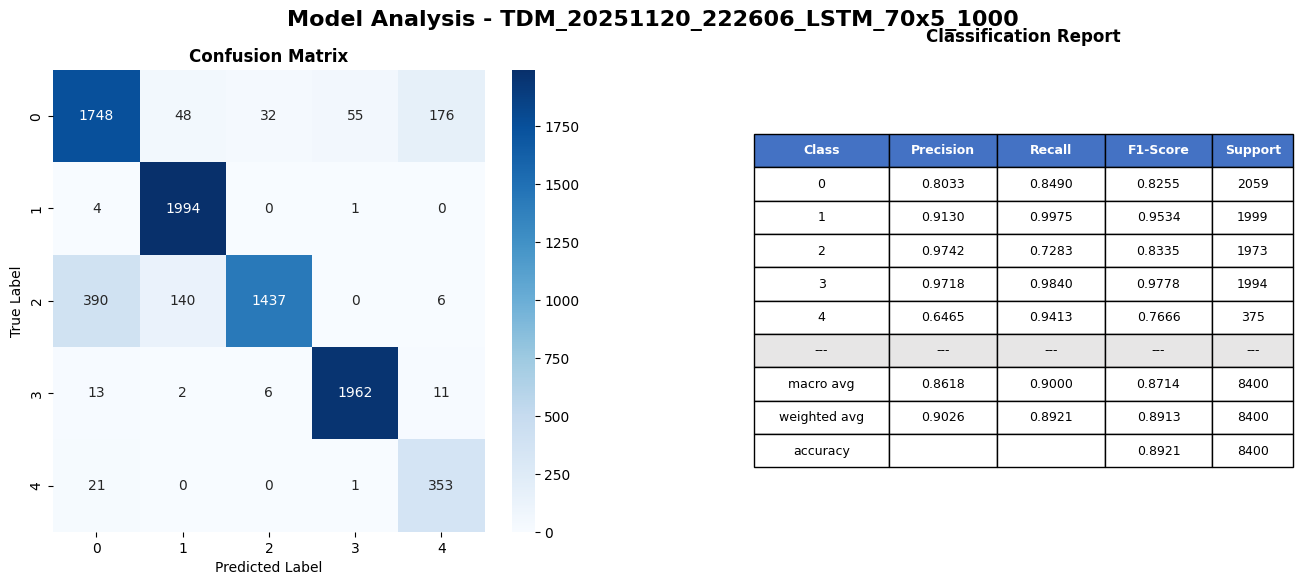

In [19]:
cm, cr = perform_model_analysis(
    model=model_lstm,
    X_test=X_val,
    y_test=y_val,
    model_name=f"{title}_{lstm_title}",
    dir=root_dir,
    plot=True,
    logger=logger,
    device=device
)

# Move model to CPU to free up GPU memory
model_lstm = model_lstm.cpu()